# Bundled Attacks
In this notebook, we'll show some example code for how to use the bundled attacks.
For a comprehensive discussion of the technique known as **attack bundling**, see this technical report from Goodfellow for `cleverhans` (remember, `mister_ed` was started as a pytorch equivalent of `cleverhans`, so any advances in evaluation methodology should be reproducible in this repo): https://arxiv.org/pdf/1811.03685.pdf

## Contents
- Overview/Limitations
- Building general attack bundles
- Building max-loss bundles 
- Building min-perturbation bundles 
- Building misclassify bundles

# Overview

Attack bundling works by selecting a set of attacks to run on the same set of examples. Then for each provided example, we take the 'best' adversarial example generated by the set of attacks. Here, 'best', is defined according to one of three different **goals**: 
- `max_loss`: We take the adversarial example that maximizes loss, according to a specified loss function 
- `min_perturbation`: We take the adversarial example that minimizes the perturbation, according to a specified perturbation norm
- `min_successful_perturbation`: We take the adversarial example that minimizes perturbation norm across successful attacks only. 
- `misclassify`: We lazily evaluate the attacks to only induce misclassification once per example. 

## Example usages in practice:
There are several nice use cases for why one might want to use attack bundling in practice:
- `MaxConfidence` attack: This is an attack outlined in https://openreview.net/pdf?id=H1g0piA9tQ, where the goal is to compute several attacks on each clean example and take the 'best' example. See table 3 here https://arxiv.org/pdf/1811.03685.pdf for a nice description of why this is nice.
- Random restarts: This is one clean way to fold many random restarts for PGD attacks (or other attacks that rely on randomness)
- Speeding up attacks: Clever ordering of attacks can drastically speed up adversarial example computation. e.g., the attacks bundled can be the FGSM, PGD-with-10-iterations, PGD-with-100-iterations, PGD-with-1000-iterations, where each attack will only compute on clean examples that were not successfully attacked using the previous attacks. 

## Limitations:
Currently we only handle attack bundling for a single `ThreatModel`: i.e., the set of allowable perturbations is a $\delta$-addition of bounded $\ell_p$ norm, or a rotation of angle at most $\theta$. Also `min_successful_perturbation` isn't implemented as of yet. 


# Setup and building general attack bundles
Similar to building adversarial attacks in general (see `tutorial_1.ipynb`) we need to import a bunch of things, and set up a model, normalizer, dataset, threat model, attack objects and their corresponding attack parameters. 


In [1]:
# IMPORT BLOCK 1

import numpy as np 
import scipy 

import torch # Need torch version >= 0.3 or 0.4
import torch.nn as nn 
import torch.optim as optim 
assert float(torch.__version__[:3]) >= 0.3



In [2]:
# IMPORT BLOCK 2
# (here we do things so relative imports work )
# Universal import block 
# Block to get the relative imports working 
import os
import sys 
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


import config
import prebuilt_loss_functions as plf
import loss_functions as lf 
import utils.pytorch_utils as utils
import utils.image_utils as img_utils
import cifar10.cifar_loader as cifar_loader
import cifar10.cifar_resnets as cifar_resnets
import adversarial_training as advtrain
import adversarial_evaluation as adveval
import utils.checkpoints as checkpoints
import adversarial_perturbations as ap 
import adversarial_attacks as aa
import spatial_transformers as st
import bundled_attacks as ba

In [3]:
# DATA/MODEL/NORMALIZER LOADER
cifar_valset = cifar_loader.load_cifar_data('val', batch_size=16)
examples, labels = next(iter(cifar_valset))

model, normalizer = cifar_loader.load_pretrained_cifar_resnet(flavor=32, return_normalizer=True)

if utils.use_gpu():
    examples = examples.cuda()
    labels = labels.cuda() 
    model.cuda()

Files already downloaded and verified


In [4]:
# THREAT MODEL AND ATTACK OBJECTS
attack_loss = plf.VanillaXentropy(model, normalizer)
delta_threat = ap.ThreatModel(ap.DeltaAddition, {'lp_style': 'inf', 
                                                 'lp_bound': 8.0 / 255}) 

# PGD and FGSM attacks

# NOTE: AttackBundles take in AdversarialAttackParameter objects 
# This is because we need full attack keywords/hyperparameters
pgd_attack = aa.PGD(model, normalizer, delta_threat, attack_loss)
pgd_params = advtrain.AdversarialAttackParameters(pgd_attack)

fgsm_attack = aa.FGSM(model, normalizer, delta_threat, attack_loss)
fgsm_params = advtrain.AdversarialAttackParameters(fgsm_attack)

attack_params = {'fgsm': fgsm_params, 
                 'pgd': pgd_params}


# Building `max_loss` Bundles

In [5]:
# With a model, normalizer, threat model, and attack parameters all set,
# we can build the AttackBundle instance with the 'max-loss' goal
max_loss_bundle = ba.AttackBundle(model, normalizer, delta_threat, attack_params, goal='max_loss')

By default the 'loss' we want to maximize will be the CrossEntropyLoss between the adversarial_examples and the labels

$$\mathcal{L}(x, y) = crossEntropy(f_\theta(atk(x), y))$$

But you can provide a different loss to maximize if you like. The important thing is that loss functions here need to have the signature 

```def loss(perturbation, labels): 
    ...
    ...
```

and output a tensor of shape $(N)$ for a perturbation on $N$ examples. This is typically attained through the kwarg `output_per_example=True` when calling the `RegularizedLoss.forward(...)` function. Take a look at `AttackBundle` method `_default_loss_for_max_loss` to see how this is done. 

Any custom loss function will be supplied to the `AttackBundle` object under the keyword argument `goal_params` upon initialization.

In [6]:
# With our existing bundled attack object, we just have to run the attack on the (examples, labels)
# This will run each attack in the bundle and take the max loss adversarial example for each clean example

max_loss_perturbation = max_loss_bundle.attack(examples, labels, verbose=True)


Running attack fgsm
(Post FGSM):  6.25 correct
Running attack pgd
(START):  87.5 correct
(iteration 00):  43.75 correct
(iteration 01):  18.75 correct
(iteration 02):  6.25 correct
(iteration 03):  0.0 correct
(iteration 04):  0.0 correct
(iteration 05):  0.0 correct
(iteration 06):  0.0 correct
(iteration 07):  0.0 correct
(iteration 08):  0.0 correct
(iteration 09):  0.0 correct
(iteration 10):  0.0 correct
(iteration 11):  0.0 correct
(iteration 12):  0.0 correct
(iteration 13):  0.0 correct
(iteration 14):  0.0 correct
(iteration 15):  0.0 correct
(iteration 16):  0.0 correct
(iteration 17):  0.0 correct
(iteration 18):  0.0 correct
(iteration 19):  0.0 correct


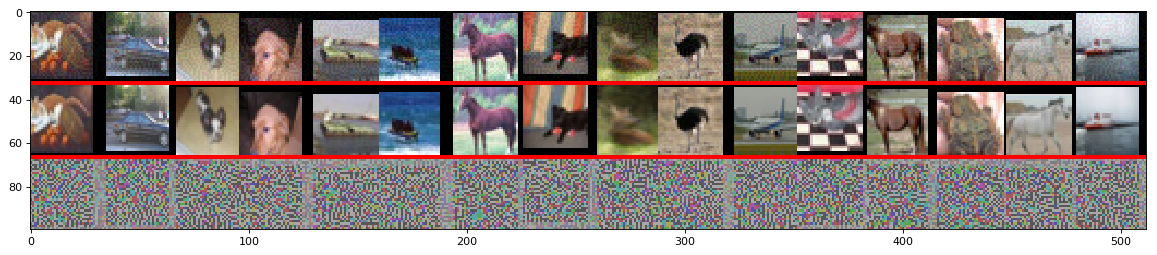

In [7]:
max_loss_perturbation.display()

# Building `min_perturbation` Bundles

In [8]:
# Building `min_perturbation` Bundles
# With a model, normalizer, threat model, and attack parameters all set,
# we can build the AttackBundle instance with the 'min_perturbation' goal
min_pert_bundle = ba.AttackBundle(model, normalizer, delta_threat, attack_params, goal='min_perturbation')


By default the perturbation norm corresponds to the threatModel specified, e.g. An $\ell_{\infty}$ threat model will consider minimum $\ell_\infty$ norms. Perturbation norm is only considered for 'successful' attacks, where a successful attack is defined as an attack that causes the classifier, $f_\theta$, to **not** classify the example, $x$, as the desired label $y$. 

$$
\text{pert_norm}(x, y) =
\begin{cases}
||pert|| , & \text{if } f_\theta(pert(x)) \neq y \\
+\infty, & \text{if } f_\theta(pert(x)) = y
\end{cases}
$$


A separate perturbation norm can be provided to the attack, so long as it takes in a perturbation as an argument and outputs a norm per example. Take a look at `AttackBundle` method `_default_norm_for_min_perturbation` to see how this is done. 

Any custom perturbation norm function will be supplied to the `AttackBundle` object under the keyword argument `goal_params` upon initialization.

In [9]:
min_pert_perturbation = min_pert_bundle.attack(examples, labels)

(Post FGSM):  6.25 correct
torch.cuda.FloatTensor
torch.cuda.LongTensor
(START):  87.5 correct
(iteration 00):  43.75 correct
(iteration 01):  18.75 correct
(iteration 02):  6.25 correct
(iteration 03):  0.0 correct
(iteration 04):  0.0 correct
(iteration 05):  0.0 correct
(iteration 06):  0.0 correct
(iteration 07):  0.0 correct
(iteration 08):  0.0 correct
(iteration 09):  0.0 correct
(iteration 10):  0.0 correct
(iteration 11):  0.0 correct
(iteration 12):  0.0 correct
(iteration 13):  0.0 correct
(iteration 14):  0.0 correct
(iteration 15):  0.0 correct
(iteration 16):  0.0 correct
(iteration 17):  0.0 correct
(iteration 18):  0.0 correct
(iteration 19):  0.0 correct
torch.cuda.FloatTensor
torch.cuda.LongTensor


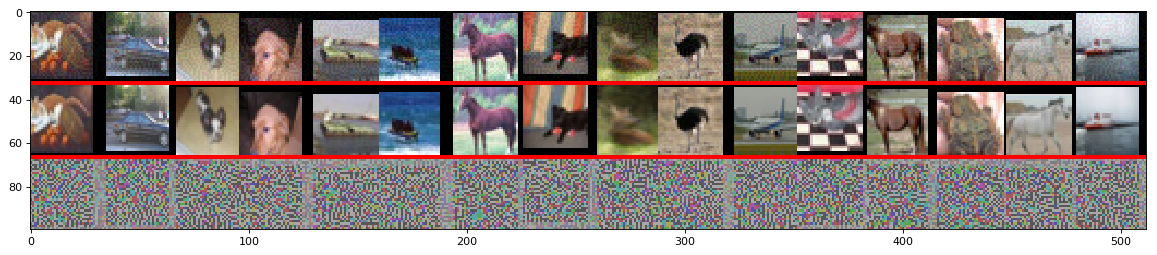

In [10]:
min_pert_perturbation.display()

# Building `misclassify` Bundles

In [11]:
# Building `min_perturbation` Bundles
# With a model, normalizer, threat model, and attack parameters all set,
# we can build the AttackBundle instance with the 'misclassify' goal

# NOTE: since misclassification is evaluated lazily, 
#       the goal_params kwarg here is the desired order to run the attacks. 
#       If no such order is provided, the default dict.keys() order is used 
misclassify_bundle = ba.AttackBundle(model, normalizer, delta_threat, attack_params, 
                                     goal='misclassify', goal_params=['fgsm', 'pgd'])

Running attack fgsm on 16 examples
(Post FGSM):  6.25 correct
Running attack pgd on 1 examples
(START):  100.0 correct
(iteration 00):  100.0 correct
(iteration 01):  100.0 correct
(iteration 02):  100.0 correct
(iteration 03):  0.0 correct
(iteration 04):  0.0 correct
(iteration 05):  0.0 correct
(iteration 06):  0.0 correct
(iteration 07):  0.0 correct
(iteration 08):  0.0 correct
(iteration 09):  0.0 correct
(iteration 10):  0.0 correct
(iteration 11):  0.0 correct
(iteration 12):  0.0 correct
(iteration 13):  0.0 correct
(iteration 14):  0.0 correct
(iteration 15):  0.0 correct
(iteration 16):  0.0 correct
(iteration 17):  0.0 correct
(iteration 18):  0.0 correct
(iteration 19):  0.0 correct


In [12]:
# NOTE^2: This should run faster than the other attacks, since we evaluate lazily
#
misclassify_pert = misclassify_bundle.attack(examples, labels, verbose=True)


NameError: name 'bundle' is not defined

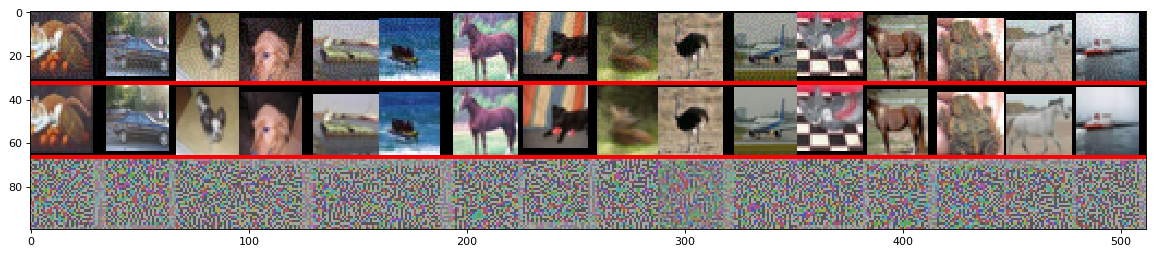

In [13]:
misclassify_pert.display()